In [1]:
# Dependencies
import datetime as dt
import pandas as pd
import yfinance as yf
import numpy as np
import math
import matplotlib.pyplot as plt

## 0 Define Stock Parameters

In [2]:
# Stock Parameters
ticker = 'NFLX'
start = '2018-11-01'
end = '2020-01-01'

## 1 Download and Process Data

In [3]:
# Download pricing data
total_dat = yf.Ticker(ticker).history(period='max').iloc[:,1:2].values

# Train-Test split
train_part = 0.80
train_split = np.arange(math.floor(train_part*len(total_dat)))
test_split = np.arange(math.floor(train_part*len(total_dat)), len(total_dat))

train_dat = total_dat[train_split]
test_dat = total_dat[test_split]

# interoplate missing values
def interp_nan(x):
    array = x[:,0]
    indicies = np.where(np.isnan(array))[0]
    indicies = [int(x) for x in indicies]
    for ix in indicies:
        if (ix != 0) & (ix != len(array)):
            array[ix] = (array[ix-1]+array[ix+1])/2
        elif ix == len(array):
            array[ix] = array[ix-1]
        else:
            array[ix] = array[ix+1]
    return array.reshape((len(array),1))

train_dat = interp_nan(train_dat)
test_dat = interp_nan(test_dat)

# Feature Scaling
# We will use "Normalization" (value-min)/range instead of standardization
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
train_dat_scaled = sc.fit_transform(train_dat)
# will feature scale the test data later

# Creating a data structure with n timesteps and 1 output
ts = 30 # timesteps
X_train = []
y_train = []
for i in range(ts, len(train_dat_scaled)):
    X_train.append(train_dat_scaled[i-ts:i, 0])
    y_train.append(train_dat_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# this is where we scale the test data
inputs = total_dat[len(train_dat) - len(test_dat) - ts:]
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(ts, ts+len(test_dat)):
    X_test.append(inputs[i-ts:i, 0])
X_test = np.array(X_test)


# Reshaping
# ** we need to reshape to a 3D tensor as that is what is expected
# add that last one in order to signify how many indicators we have
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

## 2 Building the RNN

In [4]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
# will only specify the last 2 diminensions because the observations dimension (0) is already assumed
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.1))

# Adding a second LSTM layer and some Dropout regulariation
regressor.add(LSTM(units = 75, return_sequences = True))
regressor.add(Dropout(0.1))

# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 30))
regressor.add(Dropout(0.1))

# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Summary
regressor.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30, 75)            37800     
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 75)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 30)                12720     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 31        
Total para

### 2.1 Train the Model

In [5]:
# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 10, batch_size = 20)

Epoch 1/10
3804/3804 [==============================] - 46s 12ms/step - loss: 0.0043
Epoch 2/10
3804/3804 [==============================] - 39s 10ms/step - loss: 9.2108e-04
Epoch 3/10
3804/3804 [==============================] - 39s 10ms/step - loss: 8.5157e-04
Epoch 4/10
3804/3804 [==============================] - 38s 10ms/step - loss: 7.6244e-04
Epoch 5/10
3804/3804 [==============================] - 40s 10ms/step - loss: 7.9992e-04
Epoch 6/10
3804/3804 [==============================] - 41s 11ms/step - loss: 7.4017e-04
Epoch 7/10
3804/3804 [==============================] - 39s 10ms/step - loss: 6.6017e-04
Epoch 8/10
3804/3804 [==============================] - 40s 11ms/step - loss: 5.6674e-04
Epoch 9/10
3804/3804 [==============================] - 40s 10ms/step - loss: 5.9353e-04
Epoch 10/10
3804/3804 [==============================] - 39s 10ms/step - loss: 6.1681e-04


### 2.2 Generate Forecast

In [15]:
# predict future price
pred_dat = regressor.predict(X_test)
pred_dat = sc.inverse_transform(pred_dat) 
pred_dat = pred_dat + (train_dat[-1] - pred_dat[0])
pred_dat = np.concatenate((train_dat[:,0], pred_dat[:,0]))

### 2.3 Plot Results

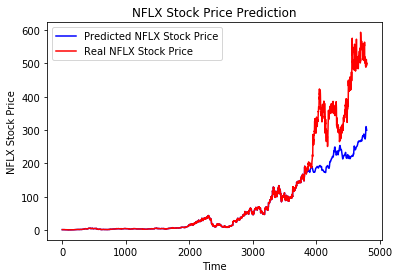

In [16]:
# Visualising the results
plt.plot(pred_dat, color = 'blue', label = f'Predicted {ticker} Stock Price')
plt.plot(total_dat, color = 'red', label = f'Real {ticker} Stock Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(f'{ticker} Stock Price')
plt.legend()
plt.show()